This notebook demonstrates the simplest workflow for generating a region-probability time series:

1. Load precomputed **MESSENGER region probability maps** (NetCDF)
2. Load or define a **spacecraft trajectory** (time + position)
3. Plot the trajectory on top of the probability map coverage
4. Sample the probability maps along the trajectory to build a **time series**
5. Plot the resulting region-probability time series

In [189]:
from pathlib import Path
import datetime as dt
import sys

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import spiceypy as spice
import astropy.units as u

from hermpy.utils import Constants
from hermpy.net import ClientSPICE
from hermpy.data import rotate_to_aberrated_coordinates
from planetary_coverage import MetaKernel
from astropy.table import QTable
from astropy.time import Time
from matplotlib.patches import Circle
from matplotlib.dates import DateFormatter, num2date, date2num
from scipy.signal.windows import boxcar

In [190]:
project_root_path = Path("../..")

probability_maps_file_path = project_root_path / "resources/region_probability_maps.nc"
probability_maps = xr.load_dataset(probability_maps_file_path)

probability_maps

<xarray.Dataset> Size: 113kB
Dimensions:                  (X MSM': 40, CYL MSM': 32)
Coordinates:
  * X MSM'                   (X MSM') float64 320B -4.875 -4.625 ... 4.625 4.875
  * CYL MSM'                 (CYL MSM') float64 256B 0.125 0.375 ... 7.625 7.875
Data variables:
    Magnetosheath            (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosphere            (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Solar Wind               (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Minutes In Bin           (X MSM', CYL MSM') float64 10kB 0.0 0.0 ... 0.0 0.0
    N Observations           (X MSM', CYL MSM') float64 10kB 0.0 0.0 ... 0.0 0.0
    Solar Wind 95% Lower     (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Solar Wind 95% Upper     (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosheath 95% Lower  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosheath 95% Upper  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosphere 95% Lower  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosphere 95% Upper  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan

Here we load SPICE kernels to pull the trajectory. You can load you trajectory of interest in any maner.

In [191]:
# Load the required spice kenels
spice_client = ClientSPICE()

# Planetary coverage has some nice code to handle updating path values for
# spice metakernels at runtime.
bepi_metakernel = MetaKernel(
    project_root_path
    / "resources/bepicolombo-spice/kernels/mk/bc_ops.tm",
    kernels=project_root_path
    / "resources/bepicolombo-spice/kernels/",
)

spice_client.add_local_kernels(bepi_metakernel.kernels)


In [192]:
with spice_client.KernelPool():
    times = [dt.datetime(2025, 1, 8, 5) + i * dt.timedelta(minutes=1) for i in range(120)]
    ets = spice.datetime2et(times)
    positions, _ = spice.spkpos("MPO", ets, "BC_MSM", "NONE", "MERCURY")

positions

array([[-5.26366708e+03, -7.44214943e+02, -9.35540239e+03],
       [-5.24839611e+03, -7.37669757e+02, -9.19080213e+03],
       [-5.23277606e+03, -7.31076698e+02, -9.02559138e+03],
       [-5.21679268e+03, -7.24434082e+02, -8.85975478e+03],
       [-5.20043090e+03, -7.17740159e+02, -8.69327635e+03],
       [-5.18367476e+03, -7.10993072e+02, -8.52613952e+03],
       [-5.16650739e+03, -7.04190880e+02, -8.35832710e+03],
       [-5.14891086e+03, -6.97331517e+02, -8.18982122e+03],
       [-5.13086617e+03, -6.90412815e+02, -8.02060333e+03],
       [-5.11235314e+03, -6.83432487e+02, -7.85065413e+03],
       [-5.09335031e+03, -6.76388103e+02, -7.67995359e+03],
       [-5.07383482e+03, -6.69277102e+02, -7.50848089e+03],
       [-5.05378235e+03, -6.62096775e+02, -7.33621436e+03],
       [-5.03316694e+03, -6.54844239e+02, -7.16313148e+03],
       [-5.01196089e+03, -6.47516441e+02, -6.98920884e+03],
       [-4.99013458e+03, -6.40110134e+02, -6.81442209e+03],
       [-4.96765632e+03, -6.32621878e+02

We now calculate the probabilities and their confidence intervals based on the region maps using:
`get_probabilitiy_at_position()` from `src/get_probabilities.py`

In [193]:
sys.path.insert(0, str(project_root_path / "src"))

from get_probabilities import get_probability_at_position

# The function expects an astropy quantity table with columns: ["UTC", "X MSM'", "Y MSM'", "Z MSM'"]

positions_table = QTable(
    [
        Time(times),
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
    ],
    names=["UTC", "X MSM", "Y MSM", "Z MSM"],
    units=["", "km", "km", "km"],
)

with spice_client.KernelPool():
    positions_table = rotate_to_aberrated_coordinates(positions_table)

probabilities, lower_ci, upper_ci = get_probability_at_position(positions_table, probability_maps)

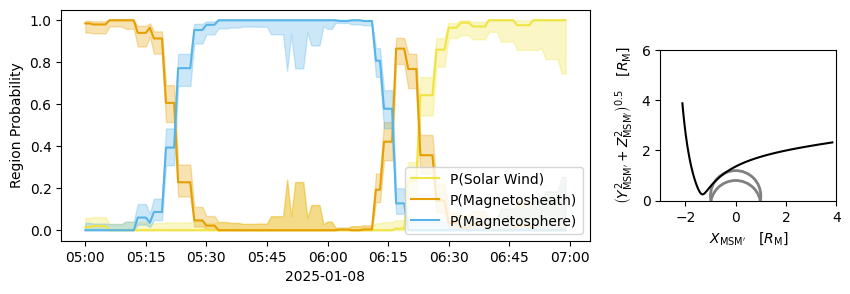

In [194]:
fig, axes = plt.subplots(1, 2, width_ratios=[3,1], figsize=(10, 3))
timeseries_ax, trajectory_ax = axes

regions = ["Solar Wind", "Magnetosheath", "Magnetosphere"]
colours = ["#F0E442", "#E69F00", "#56B4E9"]
for i, name in enumerate(regions):

    timeseries_ax.plot(times, probabilities[i], color=colours[i], label=f"P({name})")

    timeseries_ax.fill_between(
        times,
        lower_ci[i],
        upper_ci[i],
        color=colours[i],
        alpha=0.3,
    )

timeseries_ax.legend(loc="lower right")
timeseries_ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

timeseries_ax.set_xlabel("2025-01-08")
timeseries_ax.set_ylabel("Region Probability")


x = positions_table["X MSM'"] / Constants.MERCURY_RADIUS.to(u.km)
y = positions_table["Y MSM'"] / Constants.MERCURY_RADIUS.to(u.km)
z = positions_table["Z MSM'"] / Constants.MERCURY_RADIUS.to(u.km)
rho = np.sqrt(y**2 + z**2)

trajectory_ax.plot(x, rho, color="black")

trajectory_ax.set_aspect("equal")
trajectory_ax.set_xlim(-3, 4)
trajectory_ax.set_ylim(0, 6)

trajectory_ax.set_xlabel(r"$X_{\rm MSM'} \quad \left[ R_{\rm M} \right]$")
trajectory_ax.set_ylabel(r"$\left( Y_{\rm MSM'}^2 + Z_{\rm MSM'}^2 \right)^{0.5} \quad \left[ R_{\rm M} \right]$")

# Add Mercury
circle = Circle(
    (0, Constants.DIPOLE_OFFSET / Constants.MERCURY_RADIUS),
    1,
    edgecolor="grey",
    facecolor="none",
    linewidth=2,
    zorder=-5,
)
trajectory_ax.add_patch(circle)
circle = Circle(
    (0, -1 * Constants.DIPOLE_OFFSET / Constants.MERCURY_RADIUS),
    1,
    edgecolor="grey",
    facecolor="none",
    linewidth=2,
    zorder=-5,
)
trajectory_ax.add_patch(circle)

This output is somewhat blocky, due to the size of region map cells. We can't make the cells much smaller without increasing the uncertainties, but we can instead smooth the output.

The following is a simple moving average on the values and uncertainties:

In [ ]:
def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    
    return np.convolve(data, weights, mode="valid")

n=10
times = num2date(moving_average(date2num(times), n))
probabilities = [moving_average(a, n) for a in probabilities]
lower_ci = [moving_average(a, n) for a in lower_ci]
upper_ci = [moving_average(a, n) for a in upper_ci]

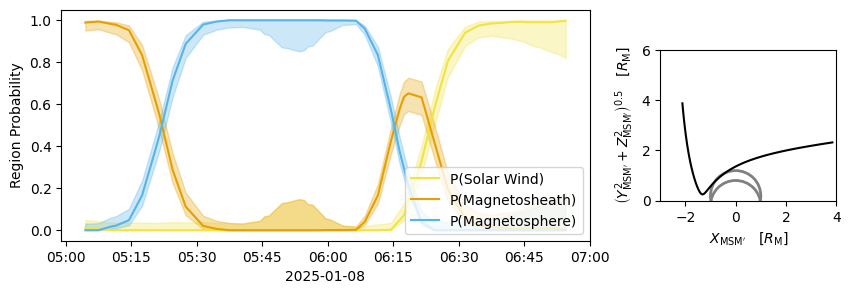

In [196]:
fig, axes = plt.subplots(1, 2, width_ratios=[3,1], figsize=(10, 3))
timeseries_ax, trajectory_ax = axes

regions = ["Solar Wind", "Magnetosheath", "Magnetosphere"]
colours = ["#F0E442", "#E69F00", "#56B4E9"]
for i, name in enumerate(regions):

    timeseries_ax.plot(times, probabilities[i], color=colours[i], label=f"P({name})")

    timeseries_ax.fill_between(
        times,
        lower_ci[i],
        upper_ci[i],
        color=colours[i],
        alpha=0.3,
    )

timeseries_ax.legend(loc="lower right")
timeseries_ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

timeseries_ax.set_xlabel("2025-01-08")
timeseries_ax.set_ylabel("Region Probability")


x = positions_table["X MSM'"] / Constants.MERCURY_RADIUS.to(u.km)
y = positions_table["Y MSM'"] / Constants.MERCURY_RADIUS.to(u.km)
z = positions_table["Z MSM'"] / Constants.MERCURY_RADIUS.to(u.km)
rho = np.sqrt(y**2 + z**2)

trajectory_ax.plot(x, rho, color="black")

trajectory_ax.set_aspect("equal")
trajectory_ax.set_xlim(-3, 4)
trajectory_ax.set_ylim(0, 6)

trajectory_ax.set_xlabel(r"$X_{\rm MSM'} \quad \left[ R_{\rm M} \right]$")
trajectory_ax.set_ylabel(r"$\left( Y_{\rm MSM'}^2 + Z_{\rm MSM'}^2 \right)^{0.5} \quad \left[ R_{\rm M} \right]$")

# Add Mercury
circle = Circle(
    (0, Constants.DIPOLE_OFFSET / Constants.MERCURY_RADIUS),
    1,
    edgecolor="grey",
    facecolor="none",
    linewidth=2,
    zorder=-5,
)
trajectory_ax.add_patch(circle)
circle = Circle(
    (0, -1 * Constants.DIPOLE_OFFSET / Constants.MERCURY_RADIUS),
    1,
    edgecolor="grey",
    facecolor="none",
    linewidth=2,
    zorder=-5,
)
trajectory_ax.add_patch(circle);